# Non-Linear 2D

Let us focus to the NL mismatch in a simple 2D non-lineal (NL) system. The problem reduce in observing how an arbitrary distribution filament in a NL topology.

```bash
pip install nafflib
pip install pytori
pip install sympy
```


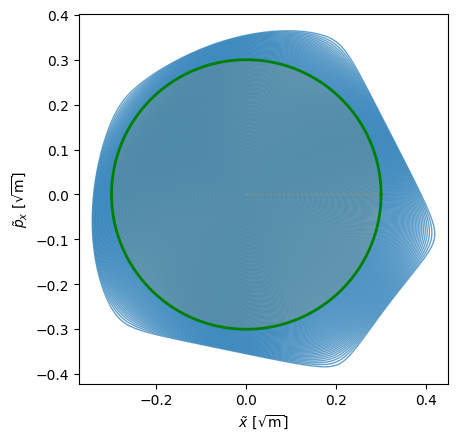

In [195]:
import numpy as np
import matplotlib.pyplot as plt

import nafflib
import pytori as pt
import pytori.plotting as ptplt

# =======================
# Mesh parameters
x_tori_number = 199
x_start = np.linspace(0.0001,0.328,x_tori_number)
angular_points_number = 500
# ======================

# ========================
# Henon parameters
num_turns   = int(0.5e4)
Q0          = 0.2071
# ========================


# Generating tori
px_start   = 0.37 * x_start

tori    = []
for x0, px0 in zip(x_start, px_start):
    # Iterating Henon map
    x, px   = nafflib.henon_map(x0, px0, Q0, num_turns)

    # Extracting harmonics:
    #============================================================================
    n_harm  = 50
    w_order = 4
    Ax,Qx   = nafflib.harmonics(x,px,num_harmonics = n_harm,window_order=w_order)
    #============================================================================

    # Indexing harmonics
    #============================================================================
    max_n       = 90 #(high numbers needed in 2D..)
    max_alias   = 50
    warning_tol = np.inf #Disable warnings
    Qvec    = [Qx[0]]
    nx      = nafflib.linear_combinations(Qx,Qvec = Qvec,max_n=max_n,max_alias=max_alias,warning_tol=warning_tol)
    #============================================================================

    # Building torus (2D-torus)
    #============================================================================
    _torus = pt.Torus.from_naff(n=[nx],A=[Ax])
    tori.append(_torus)
    #============================================================================


# Plotting
#--------------------------------------------------

# %%

plt.figure()
for torus in tori:
    # Full loop around 0-2pi
    ptplt.xloop(torus,num_points=200,edgecolor='C0',alpha=0.7,lw=1)

    # Free hand plot of the torus
    Tx = np.linspace(0-np.pi/8,2*np.pi-np.pi/8,50) # Theta_x values
    #plt.plot(torus.X(Tx), torus.PX(Tx),'-',color='C3',lw=1)
    #plt.plot(torus.X(Tx[0]), torus.PX(Tx[0]),'o',color='C3',ms=3)
    #plt.plot(torus.X(Tx[:-1]), torus.PX(Tx[:-1]),'-',color='C3',ms=3.5,alpha=0.2)




plt.axis('equal')
plt.gca().set_box_aspect(1) 
plt.xlabel(r'$\tilde x\ [\sqrt{\mathrm{m}}]$');
plt.ylabel(r'$\tilde p_x\ [\sqrt{\mathrm{m}}]$');

# plot an annulus from 0.1 to 0.3
annulus_inner = 0
annulus_outer = 0.3
theta = np.linspace(0, 2 * np.pi, angular_points_number)
# outer circle
x_outer = annulus_outer * np.cos(theta[::-1])
px_outer = annulus_outer * np.sin(theta[::-1])

# inner circle (reverse direction to make a proper closed annulus)
x_inner = annulus_inner * np.cos(theta)
px_inner = annulus_inner * np.sin(theta)
  
plt.plot(x_inner, px_inner, 'g',lw=2,label='Inner Annulus')
plt.plot(x_outer, px_outer, 'g',lw=2,label='Outer Annulus')

x = np.concatenate([x_outer, x_inner])
y = np.concatenate([px_outer, px_inner])

plt.fill(x, y, color='orange', alpha=.1)
plt.gca().set_aspect('equal')
plt.show()

### Important observation

We observe that two particle belonging to the same torus positioned at $d\theta$, keep their  $d\theta$ during the rotation BUT their $dl$ along the torus is changing. To be noted that the smaller the radius of curvature of the torus, the smaller the $dl$ at constant $d\theta$.

The above information implies, that if the torus is not a circle then the matched density of the torus in not $dl$-constant along the torus. It is higher when the radius of curvature is smaller. In other words, the matched density of the torus should be $d\theta$-constant (e.g., invariant by rotation). 

(np.float64(-0.3806916184990139),
 np.float64(0.4574701341657674),
 np.float64(-0.42052736357410203),
 np.float64(0.4016538973654504))

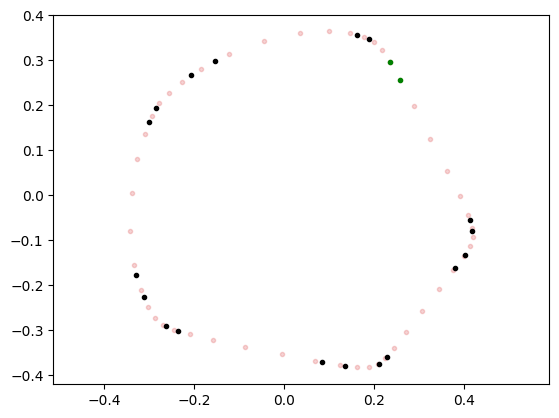

In [196]:
plt.plot(torus.X(Tx), torus.PX(Tx),'o',color='C3',ms=3, alpha=0.2)
plt.plot(torus.X(Tx[0]), torus.PX(Tx[0]),'o',color='g',ms=3)
plt.plot(torus.X(Tx[1]), torus.PX(Tx[1]),'o',color='g',ms=3)

x0 = torus.X(Tx[0])
px0 = torus.PX(Tx[0])
x1, px1   = nafflib.henon_map(x0, px0, Q0, num_turns=200)

x0 = torus.X(Tx[1])
px0 = torus.PX(Tx[1])
x2, px2   = nafflib.henon_map(x0, px0, Q0, num_turns=200)

plt.plot(x1[-5:], px1[-5:], 'ko',ms=3)
plt.plot(x2[-5:], px2[-5:], 'ko',ms=3)

plt.plot(x1[1:5], px1[1:5], 'ko',ms=3)
plt.plot(x2[1:5], px2[1:5], 'ko',ms=3)
plt.axis('equal')

### Meshing the phase space

For our objective, we cannot simply sample the phase space but mesh it. The mesh grid will be defined by the discrete sequence of actions (tori) and angles. 
Each node of the mesh needs to be metric by the area attached to the node. The mesh we use is homothetic to a polar grid (normal form) but we operate on the physical linear normalized space. For semplicity we use the number of angles considered is J-independent (4-node quadrilateral mesh). In other words the weight of the node is something similar to $rdr\theta$, the elementary area in polar coordinates. 

In [198]:
import numpy as np

def annulus(x, y, annulus_inner, annulus_outer):
    # Convert to numpy arrays (no effect if they are already arrays)
    x = np.asarray(x)
    y = np.asarray(y)

    r2 = x**2 + y**2
    return np.where((annulus_inner**2 <= r2) & (r2 <= annulus_outer**2), 1, 0)

def area_quadrilateral(x1, px1, x2, px2, x3, px3, x4, px4):
    # split into two triangles
    area1 = 0.5 * np.abs(x1*(px2 - px3) + x2*(px3 - px1) + x3*(px1 - px2))
    area2 = 0.5 * np.abs(x1*(px3 - px4) + x3*(px4 - px1) + x4*(px1 - px3))
    return area1 + area2 

def annulus_weighted(Q, P, annulus_inner, annulus_outer):
    """
    Evaluate annulus membership and weight by distance between consecutive points.
    
    Parameters:
    -----------
    Q : np.array
        Array of Q coordinates (shape: N)
    P : np.array  
        Array of P coordinates (shape: N)
    annulus_inner : float
        Inner radius of annulus
    annulus_outer : float
        Outer radius of annulus
        
    Returns:
    --------
    weights : np.array
        Array of weights for each point. Points outside annulus get weight 0.
        Points inside annulus get weight proportional to distance from previous point.
    """
    Q = np.asarray(Q)
    P = np.asarray(P)
    
   
    
    # Binary mask for points in annulus
    value = annulus(Q, P, annulus_inner, annulus_outer)
    
    
    
    # Calculate distances between consecutive points
    area = 1
    for ii in range(1,x_tori_number):
        for jj in range(angular_points_number-1):
            area = 1
    #        area = 1 #area_quadrilateral(x[ii-1,jj-1], px[ii-1,jj-1],
                        #   x[ii-1,jj], px[ii-1,jj],
                        #   x[ii,jj], px[ii,jj],
                        #   x[ii,jj-1], px[ii,jj-1]))
    # Weight by distance, but only for points in annulus
    weights = value * area
    
    return weights

my_Q = []
my_P = []
my_density = []
my_average_density = []

for torus in tori: 
    looping = 'x'
    Tx = np.linspace(0,2*np.pi,angular_points_number) 
    Q = torus.X(Tx)
    P = torus.PX(Tx)

    my_Q.append(Q[:-1])
    my_P.append(P[:-1])  
    density = annulus_weighted(Q[:-1], P[:-1], annulus_inner, annulus_outer)
    my_density.append(density)
    average_density = np.mean(density)
    my_average_density.append(average_density*np.ones_like(Q[:-1]))

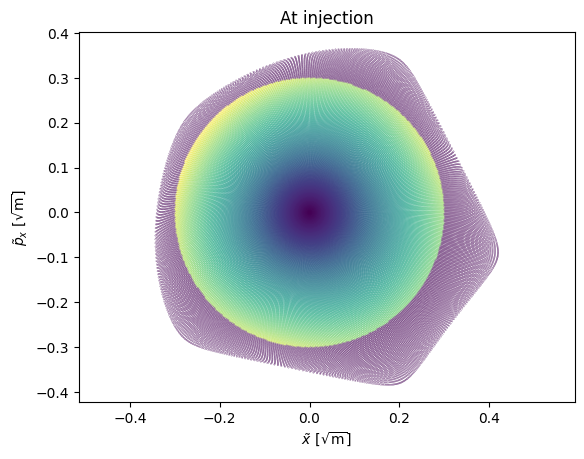

In [205]:
my_Q = []
my_P = []
my_density = []
my_average_density = []

for torus in tori: 
    looping = 'x'
    Tx = np.linspace(0,2*np.pi,angular_points_number) 
    Q = torus.X(Tx)
    P = torus.PX(Tx)
    my_Q.append(Q[:-1])
    my_P.append(P[:-1])  
Q = np.reshape(my_Q, (x_tori_number, angular_points_number-1))
P = np.reshape(my_P, (x_tori_number, angular_points_number-1))

weights = np.zeros_like(Q)
values = np.zeros_like(Q)

    
    # # Calculate distances between consecutive points
    # area = 1
for ii in range(1,x_tori_number):
    for jj in range(angular_points_number-1):
        value = annulus(Q[ii,jj], P[ii,jj], annulus_inner, annulus_outer)
        area = area_quadrilateral(Q[ii-1,jj-1], P[ii-1,jj-1],
                         Q[ii-1,jj], P[ii-1,jj],
                         Q[ii,jj], P[ii,jj],
                         Q[ii,jj-1], P[ii,jj-1])
    # Weight by distance, but only for points in annulus
        values[ii, jj] = value
        weights[ii, jj] = value * area
        
plt.scatter(Q, P, c=weights, cmap='viridis',  marker='.', s=.1)
plt.axis('equal')
plt.title('At injection')
plt.xlabel(r'$\tilde x\ [\sqrt{\mathrm{m}}]$');
plt.ylabel(r'$\tilde p_x\  [\sqrt{\mathrm{m}}]$')

# make the average of the weights along the angular direction keeping the same shape of weights
average_weights = np.mean(weights, axis=1)
average_weights = np.repeat(average_weights[:, np.newaxis], angular_points_number-1, axis=1)



Text(0, 0.5, '$\\tilde p_x\\  [\\sqrt{\\mathrm{m}}]$')

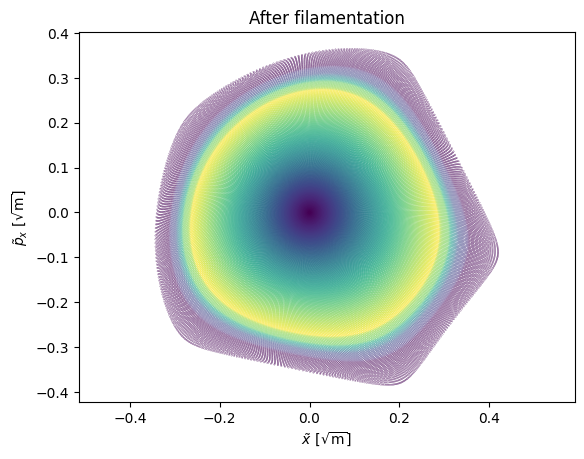

In [206]:
plt.scatter(my_Q, my_P, c=average_weights, cmap='viridis',  marker='.', s=.1)
plt.axis('equal')
plt.title('After filamentation')
plt.xlabel(r'$\tilde x\ [\sqrt{\mathrm{m}}]$');
plt.ylabel(r'$\tilde p_x\  [\sqrt{\mathrm{m}}]$')

### We compute the x-projection

It is important to observe/verify that the initial profile is the statistical projection of the initial distribution (no mesh aberration).

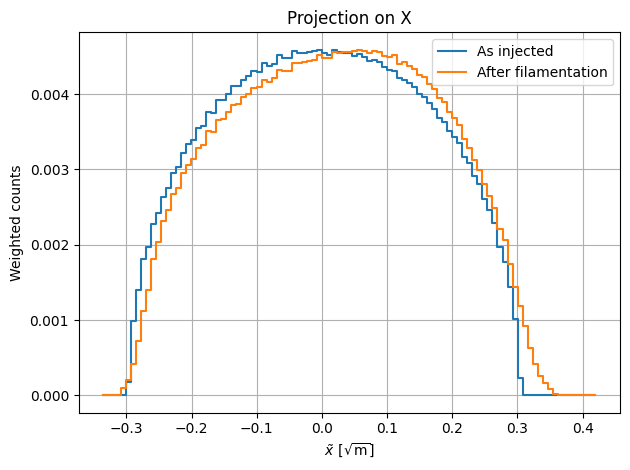

In [207]:
import numpy as np
import matplotlib.pyplot as plt

# Example arrays
# X, Y, W are 1D arrays of the same length
# X = ...
# Y = ...
# W = ...

# Bin definitions
my_Q_aux = np.concatenate(Q)
my_P_aux = np.concatenate(P)
my_average_density_aux = np.concatenate(average_weights)

steps = 100
xbins = np.linspace(min(my_Q_aux), max(my_Q_aux), steps)
ybins = np.linspace(min(my_P_aux), max(my_P_aux), steps)

# Build 2D weighted histogram
H, xedges, yedges = np.histogram2d(my_Q_aux, my_P_aux, bins=[xbins, ybins], weights=my_average_density_aux)

# Projection on X: sum over Y bins
projXX = H.sum(axis=1)

# Projection on Y: sum over X bins
projY = H.sum(axis=0)

# Plot projections

#plt.step(xedges[:-1], projXX, where='mid')


my_Q_aux = np.concatenate(Q)
my_P_aux = np.concatenate(P)
my_density_aux = np.concatenate(weights)
xbins = np.linspace(min(my_Q_aux), max(my_Q_aux), steps)
ybins = np.linspace(min(my_P_aux), max(my_P_aux), steps)

# Build 2D weighted histogram
H, xedges, yedges = np.histogram2d(my_Q_aux, my_P_aux, bins=[xbins, ybins], weights=my_density_aux)

# Projection on X: sum over Y bins
projX = H.sum(axis=1)

# Projection on Y: sum over X bins
projY = H.sum(axis=0)

# Plot projections

plt.step(xedges[1:], projX, where='mid', label='As injected')
plt.step(xedges[1:], projXX, where='mid', label='After filamentation')

plt.title("Projection on X")
plt.xlabel(r'$\tilde x\ [\sqrt{\mathrm{m}}]$')
plt.ylabel("Weighted counts")

plt.tight_layout()
plt.grid()
plt.legend()